<a href="https://colab.research.google.com/github/josephmhernandez/SeizureDetection/blob/master/Seizure_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#  Upload model weights.340.hdf5
from google.colab import files
src = list(files.upload().values())[0]

In [0]:
#Input Data. 

link_video = 'https://www.youtube.com/watch?v=ZqFK17oK2ys'
 

[youtube] ZqFK17oK2ys: Downloading webpage
[youtube] ZqFK17oK2ys: Downloading MPD manifest


[dashsegments] Total fragments: 7
[download] Destination: ZqFK17oK2yswebm.f242
[download] 100% of 538.36KiB in 00:04
[dashsegments] Total fragments: 5
[download] Destination: ZqFK17oK2ysm4a.f140
[download] 100% of 516.26KiB in 00:02
[ffmpeg] Merging formats into "ZqFK17oK2yswebm.mkv"
Deleting original file ZqFK17oK2yswebm.f242 (pass -k to keep)
Deleting original file ZqFK17oK2ysm4a.f140 (pass -k to keep)
here
Sec-vid-4.webm
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
Empty frame detected, frame number 977 of 979. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 977 of 979. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 977 of 979. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
OpenPose demo successf

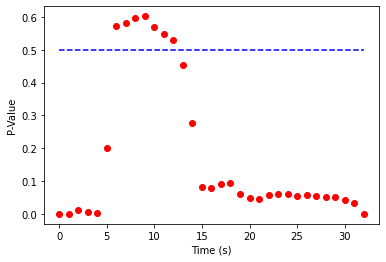

In [0]:
!pip install youtube_dl
!pip install pafy

import youtube_dl
import os
import pafy
import numpy as np


ydl = youtube_dl.YoutubeDL({'outtmpl': '%(id)s%(ext)s'})

with ydl:
    result = ydl.extract_info(
        link_video,
        download=True
    )

if 'entries' in result:
    # Can be a playlist or a list of videos
    video = result['entries'][0]
else:
    # Just a video
    video = result

# print(video)
title = video['id']

file_list = np.array(os.listdir(path=None))
video_name = None
# print(file_list)
for a in file_list:
    if(title in a):
        print('here')
        video_name = a
        break

nvideo = pafy.new(link_video)
video_duration=nvideo.length 

os.rename(video_name, nvideo.title + '.' + video['ext'])
video_name = nvideo.title + '.' + video['ext']
title = nvideo.title


print(video_name)


#Load Open Pose
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`


#Generate openPose Outputs
newvidInput = video_name 
newvidOutput = '/content/landmarks_' + title + '.avi'
newJsonOutput = title + '_landmarks1'

!./openpose/build/examples/openpose/openpose.bin --video {newvidInput} --write_video {newvidOutput} --write_json {newJsonOutput} --model_folder openpose/models --disable_blending --display 0 --number_people_max 1 --scale_number 4 --scale_gap 0.25 --keypoint_scale 3

num_landmark_outputs = len(os.listdir(newJsonOutput))



#Iterate through JSON files and save as npy files. 
import json
print('Change JSON files to npy files....')
jsonFiles = np.array(os.listdir(newJsonOutput))
rtnList = np.zeros((len(jsonFiles),50)) 
jsonFiles.sort()


for i,jsonFile in enumerate(jsonFiles): 
    with open(newJsonOutput + '/' + jsonFiles[i]) as jsonOutput:
        data = json.load(jsonOutput)
        try:
            bodyLandmarks = data['people'][0]['pose_keypoints_2d']    
            #Get rid of the confidence of points
            bodyLandmarks = [xx for p, xx in enumerate(bodyLandmarks) if p%3 !=2]
            rtnList[i,] = bodyLandmarks
        except:
            # print('oof.' + str(i))
            # print(data)
            continue

#Convert (frames, 50) np.array to a .npy file
#Fill in sparse data. 
rtnData = np.zeros((len(rtnList), 50))
_prevValues = np.zeros(50)       
for j,features in enumerate(rtnList):
    _values = np.zeros(50)
    for i,f in enumerate(features): 
        #Iterate over 50 values. 
        if f == 0:
            _values[i] = _prevValues[i]
        else:
            #f != 0:
            _values[i] = f
            _prevValues[i] = f

    rtnData[j,] = _values

np.save(title + '.npy', rtnData)

#Load model. 
from keras.models import load_model

#Define F1 score. 
import keras.backend as K
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    # Model Dependency. 
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

model_path = 'weights.340.hdf5'

#Model dependencies. 
dependencies = {
    'f1_score': f1_score,
    'precision_m': precision_m,
    'recall_m': recall_m
}
my_model = load_model(model_path, custom_objects=dependencies)


data = np.load(title + '.npy')

print('Data: ' + title)
seconds = video_duration


frames = num_landmark_outputs
fps = num_landmark_outputs / seconds



pred_data = [] #[ [timestamp (s) , p-value], ... ]
time_vals = []
pred_vals = []
for t in range(0, seconds):
    _curr_frame = round(t * fps)
    if ((_curr_frame - 40) < 0) or (_curr_frame + 40 > frames - 1):
        print('nope')
        pred_data.append([t,0])
        time_vals.append(t)
        pred_vals.append(0)
    else:
        _use = data[_curr_frame - 40 : _curr_frame + 40,]
        _pval = float(my_model.predict(x=_use.reshape(1,80,50)))
        pred_data.append([t,_pval])
        time_vals.append(t)

        pred_vals.append(_pval)

#Plot results.
import matplotlib.pyplot as plt

plt.figure()
plt.plot(time_vals, pred_vals, 'ro')
plt.xlabel('Time (s)')
plt.ylabel('P-Value')
plt.plot(range(len(time_vals)), [.5 for x in range(len(time_vals))], 'b--')
plt.savefig(title + '.png')

plt.show()

my_dict = {}
my_dict['seizure'] = pred_data
import json
with open(title + '.json', 'w') as fp:
    json.dump(my_dict, fp)

In [0]:
import numpy as np
a = np.load('Sec-vid-5.npy')
print(my_dict)

{'seizure': [[0, 0], [1, 0], [2, 0.00021640927297994494], [3, 0.0], [4, 0.0], [5, 0.0], [6, 0.0], [7, 0.0], [8, 0.0], [9, 0.0], [10, 0.0], [11, 0.0], [12, 0.0], [13, 0.0], [14, 0.0], [15, 0.0], [16, 0.0], [17, 0.0], [18, 0.0], [19, 0.0], [20, 0.0], [21, 0.0], [22, 0.0], [23, 0.0], [24, 0.0], [25, 0.0], [26, 0.0], [27, 0.0], [28, 0.0], [29, 0.0], [30, 0.0], [31, 0.0], [32, 0.0], [33, 0.0], [34, 0.0], [35, 0.0], [36, 0]]}
